In [2]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [3]:
# lstm_train_fixed.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import joblib




df = pd.read_csv("flood_model_lagged.csv")
if "date" in df.columns:
    df = df.drop(columns=["date"])

feature_cols = list(df.drop(columns=["flood"]).columns)
X_all = df[feature_cols].values.astype(float)
y_all = df["flood"].values.astype(int)

TIME_STEPS = 7

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


split_idx = int(len(X_all) * 0.8)
X_train_raw, y_train_raw = X_all[:split_idx], y_all[:split_idx]
X_test_raw,  y_test_raw  = X_all[split_idx:], y_all[split_idx:]


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)


X_train, y_train = create_sequences(X_train_scaled, y_train_raw, TIME_STEPS)
X_test,  y_test  = create_sequences(X_test_scaled,  y_test_raw,  TIME_STEPS)


assert X_train.ndim == 3 and X_test.ndim == 3, "Sequence building failed."


model = Sequential()
model.add(LSTM(64, input_shape=(TIME_STEPS, X_train.shape[2])))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1,
)


loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

save_model(model, "lstm_flood_model.h5")
meta = {
    "scaler": scaler,
    "features": feature_cols,  
    "time_steps": TIME_STEPS,
}
joblib.dump(meta, "lstm_meta.joblib")
print("Saved lstm_flood_model.h5 and lstm_meta.joblib")


Epoch 1/30


/Users/fmhadiurrahman/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9542 - loss: 0.2490 - val_accuracy: 0.9525 - val_loss: 0.1103
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9519 - loss: 0.1311 - val_accuracy: 0.9539 - val_loss: 0.0881
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9568 - loss: 0.1131 - val_accuracy: 0.9828 - val_loss: 0.0685
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9590 - loss: 0.1060 - val_accuracy: 0.9862 - val_loss: 0.0498
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9674 - loss: 0.0848 - val_accuracy: 0.9849 - val_loss: 0.0373
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9738 - loss: 0.0719 - val_accuracy: 0.9911 - val_loss: 0.0394
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9750 - loss: 0.0619 - val_accuracy: 0.9917 - val_loss: 0.0351
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9767 - loss: 0.0668 - val_accuracy: 0.9862 - val_

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1379
           1       0.95      0.93      0.94        75

    accuracy                           0.99      1454
   macro avg       0.97      0.97      0.97      1454
weighted avg       0.99      0.99      0.99      1454

💾 Saved lstm_flood_model.h5 and lstm_meta.joblib


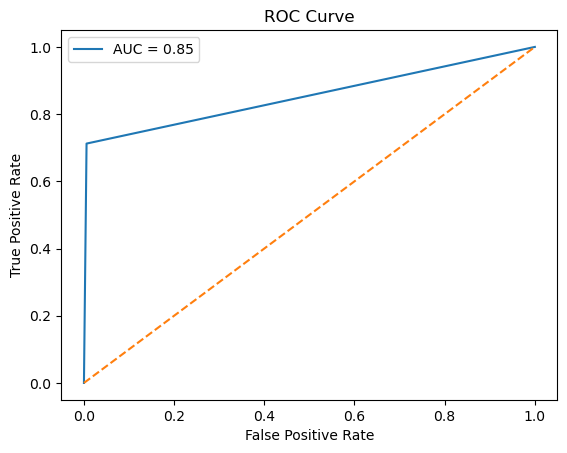

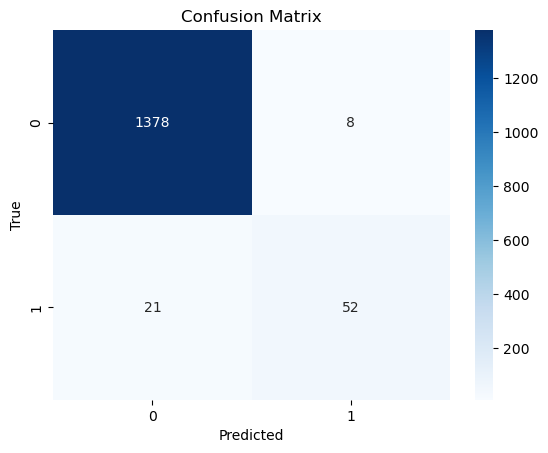

In [6]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
